# Regional Bias

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import warnings

import dask
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from tools import (
    check_equal_period,
    create_cordex_grid,
    fix_360_longitudes,
    height_temperature_correction,
    load_obs,
    mask_invalid,
    open_datasets,
    regional_means,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    variable_mapping,
)

dask.config.set(scheduler="single-threaded")

In [2]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43625,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:41361,Total threads: 1
Dashboard: http://127.0.0.1:34089/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:41561,


In [3]:
# Parameter papermill
index = "tas"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
periods = [slice("1989", "2008"), slice("1991", "2020")]
reference_regions = "PRUDENCE"

In [4]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [5]:
variable = var_dic[index]["variable"]

In [6]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [7]:
# prudence
regions = regionmask.defined_regions.prudence

In [8]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [ ]:
ref_seasmean_periods = {}
for period in periods:
    # load, regrid and calculate seasonal means
    eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
    eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
    eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
    eobs = eobs.rename({eobs_var: variable})
    eobs = standardize_unit(eobs, variable)
    # eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
    # unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
    regridder = xe.Regridder(
        eobs, rotated_grid, method=regridding, unmapped_to_nan=True
    )
    ref_on_rotated = regridder(eobs)
    if not check_equal_period(ref_on_rotated, period):
        print(f"Temporal coverage of dataset does not match with {period}")
    ref_seasmean = seasonal_mean(ref_on_rotated[variable].sel(time=period)).compute()
    ref_seasmean_periods[f"{period.start}-{period.stop}"] = ref_seasmean

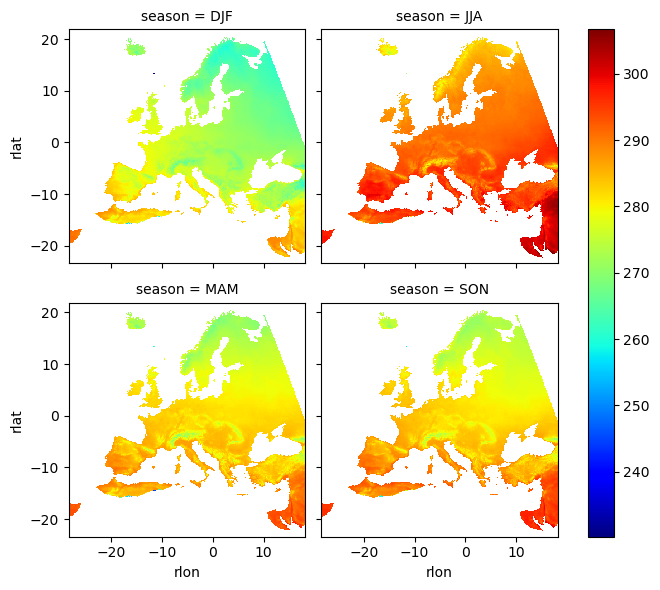

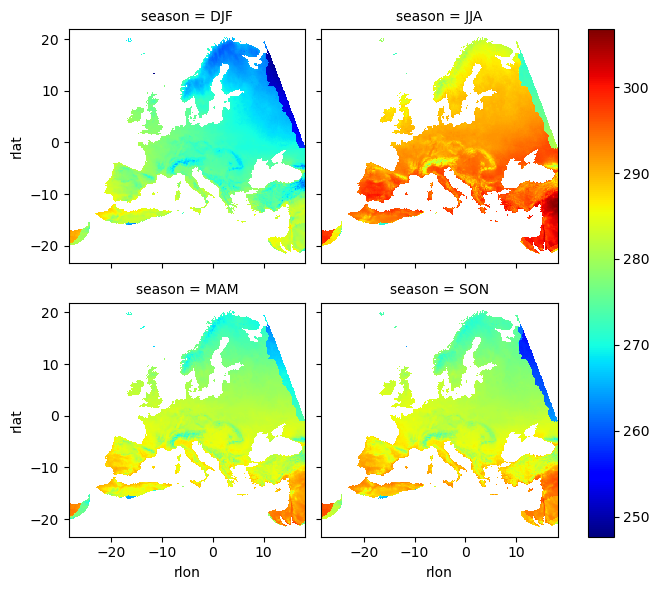

In [10]:
for period in periods:
    ref_seasmean_periods[f"{period.start}-{period.stop}"].plot(
        col="season", col_wrap=2, cmap="jet"
    )

## CERRA and ERA5

In [ ]:
for period in periods:

    # Load eobs (CERRA and ERA5)
    dsets = {}
    for dset in var_dic[variable]["datasets"]:
        ds = load_obs(variable, dset, add_fx=True, mask=True)
        ds = ds.sel(time=period).compute()
        ds = fix_360_longitudes(ds, lonname="longitude")
        if not variable_mapping[dset][variable] == variable:
            ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
        ds = standardize_unit(ds, variable)
        dsets[dset] = ds

    # Check temporal coverage
    for dset in dsets.keys():
        if not check_equal_period(dsets[dset], period):
            print(f"Temporal coverage of {dset} does not match with {period}")

    # Regrid
    for dset, ds in dsets.items():
        regridder = xe.Regridder(
            ds, rotated_grid, method=regridding, unmapped_to_nan=True
        )
        dsets[dset] = regridder(ds)

    if variable == "tas":
        for dset in dsets:
            h_c = height_temperature_correction(
                dsets[dset].orog, ref_on_rotated.elevation
            )
            dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

    # Calculate seasonal_mean bias respect to the reference dataset
    ref_seasmean = ref_seasmean_periods[f"{period.start}-{period.stop}"]
    if var_dic[variable]["diff"] == "abs":
        diffs = {
            dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
            - (ref_seasmean)
            for dset_id, ds in dsets.items()
            if variable in ds.variables
        }
    elif var_dic[variable]["diff"] == "rel":
        diffs = {
            dset_id: 100
            * (
                seasonal_mean(ds[[variable]].sel(time=period)).compute()
                - (ref_seasmean)
            )
            / (ref_seasmean)
            for dset_id, ds in dsets.items()
            if variable in ds.variables
        }
    obs_seasonal_bias = xr.concat(
        list(diffs.values()),
        dim=xr.DataArray(
            list(map(lambda x: x, diffs.keys())),
            dims="dset_id",
        ),
        compat="override",
        coords="minimal",
    )
    # Delete cell with high relative differences (arid areas for precipitation)
    obs_seasonal_bias[variable] = obs_seasonal_bias[variable].where(
        (obs_seasonal_bias[variable] <= 1000) & (obs_seasonal_bias[variable] >= -1000)
    )
    # Plot
    obs_seasonal_bias[variable].plot(row="dset_id", col="season", cmap="BrBG")
    # Calculate regional means
    obs_regions = regional_means(
        obs_seasonal_bias, regions, aggr=var_dic[index]["aggr"]
    )
    # Save results
    obs_regions.to_netcdf(
        f"{save_results_path}/{index}_obs_{reference_regions}_{period.start}-{period.stop}.nc"
    )

## CMIP6 and CMIP5

In [12]:
CMIP_dic = {
    "CMIP6": "ERA5",
    "CMIP5": "ERAINT",
}

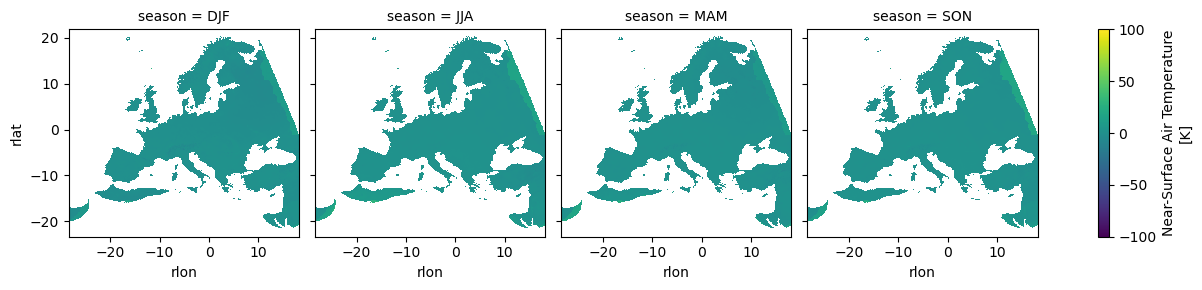

In [ ]:
for mip_era, driving_source_id in CMIP_dic.items():
    for period in periods:
        dsets = open_datasets(
            [variable],
            frequency=frequency,
            driving_source_id=driving_source_id,
            mask=True,
            add_missing_bounds=False,
        )
        for dset in dsets.keys():
            if not check_equal_period(dsets[dset], period):
                print(f"Temporal coverage of {dset} does not match with {period}")

        for dset in dsets.keys():
            dsets[dset] = standardize_unit(dsets[dset], variable)

        dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

        if variable == "tas":
            for dset in dsets:
                h_c = height_temperature_correction(
                    dsets[dset].orog, ref_on_rotated.elevation
                )
                dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

        ref_seasmean = ref_seasmean_periods[f"{period.start}-{period.stop}"]
        if var_dic[index]["diff"] == "abs":
            diffs = {
                dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
                - ref_seasmean
                for dset_id, ds in dsets.items()
                if variable in ds.variables
            }
        elif var_dic[index]["diff"] == "rel":
            diffs = {
                dset_id: 100
                * (
                    seasonal_mean(ds[[variable]].sel(time=period)).compute()
                    - (ref_seasmean)
                )
                / (ref_seasmean)
                for dset_id, ds in dsets.items()
                if variable in ds.variables
            }

        seasonal_bias = xr.concat(
            list(diffs.values()),
            dim=xr.DataArray(
                list(
                    map(
                        lambda x: short_iid(x, ["source_id"], delimiter="-"),
                        diffs.keys(),
                    )
                ),
                dims="dset_id",
            ),
            compat="override",
            coords="minimal",
        )

        seasonal_bias[variable] = seasonal_bias[variable].where(
            (seasonal_bias[variable] <= 1000) & (seasonal_bias[variable] >= -1000)
        )

        seasonal_bias[variable].isel(dset_id=0).plot(col="season", vmin=-100, vmax=100)

        dset_id_regions = regional_means(
            seasonal_bias, regions, aggr=var_dic[index]["aggr"]
        )
        dset_id_regions.to_netcdf(
            f"{save_results_path}/{index}_{mip_era}_{reference_regions}_{period.start}-{period.stop}.nc"
        )

#### Load results for both CMIP5 and CMIP6 simulations

In [14]:
seasons = ["DJF", "MAM", "JJA", "SON"]

In [15]:
period = periods[0]
dset_id_regions_CMIP6_fp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP6_{reference_regions}_{period.start}-{period.stop}.nc"
)
dset_id_regions_CMIP5_fp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP5_{reference_regions}_{period.start}-{period.stop}.nc"
)

period = periods[1]
dset_id_regions_CMIP6_sp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP6_{reference_regions}_{period.start}-{period.stop}.nc"
)
dset_id_regions_CMIP5_sp = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP5_{reference_regions}_{period.start}-{period.stop}.nc"
)

In [16]:
df_CMIP6_fp = dset_id_regions_CMIP6_fp.to_dataframe().reset_index()
df_CMIP5_fp = dset_id_regions_CMIP5_fp.to_dataframe().reset_index()

df_CMIP6_sp = dset_id_regions_CMIP6_sp.to_dataframe().reset_index()
df_CMIP5_sp = dset_id_regions_CMIP5_sp.to_dataframe().reset_index()

In [17]:
period = periods[0]
df_obs = xr.open_dataset(
    f"{save_results_path}/{index}_obs_{reference_regions}_{period.start}-{period.stop}.nc"
)
df_obs_fp = df_obs.to_dataframe().reset_index()

period = periods[1]
df_obs = xr.open_dataset(
    f"{save_results_path}/{index}_obs_{reference_regions}_{period.start}-{period.stop}.nc"
)
df_obs_sp = df_obs.to_dataframe().reset_index()

In [18]:
print(np.min(df_CMIP5_fp[variable]), np.max(df_CMIP5_fp[variable]))
print(np.min(df_CMIP6_fp[variable]), np.max(df_CMIP6_fp[variable]))

-4.174420685432006 2.5913760931730954
-3.2772043362372782 2.6295947876510604


In [19]:
print(np.min(df_CMIP5_sp[variable]), np.max(df_CMIP5_sp[variable]))
print(np.min(df_CMIP6_sp[variable]), np.max(df_CMIP6_sp[variable]))

-4.612102395800449 2.5735853814269913
-2.435699664302148 1.7785855176711485


/tmp/ipykernel_467407/1634576621.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
/tmp/ipykernel_467407/1634576621.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
/tmp/ipykernel_467407/1634576621.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

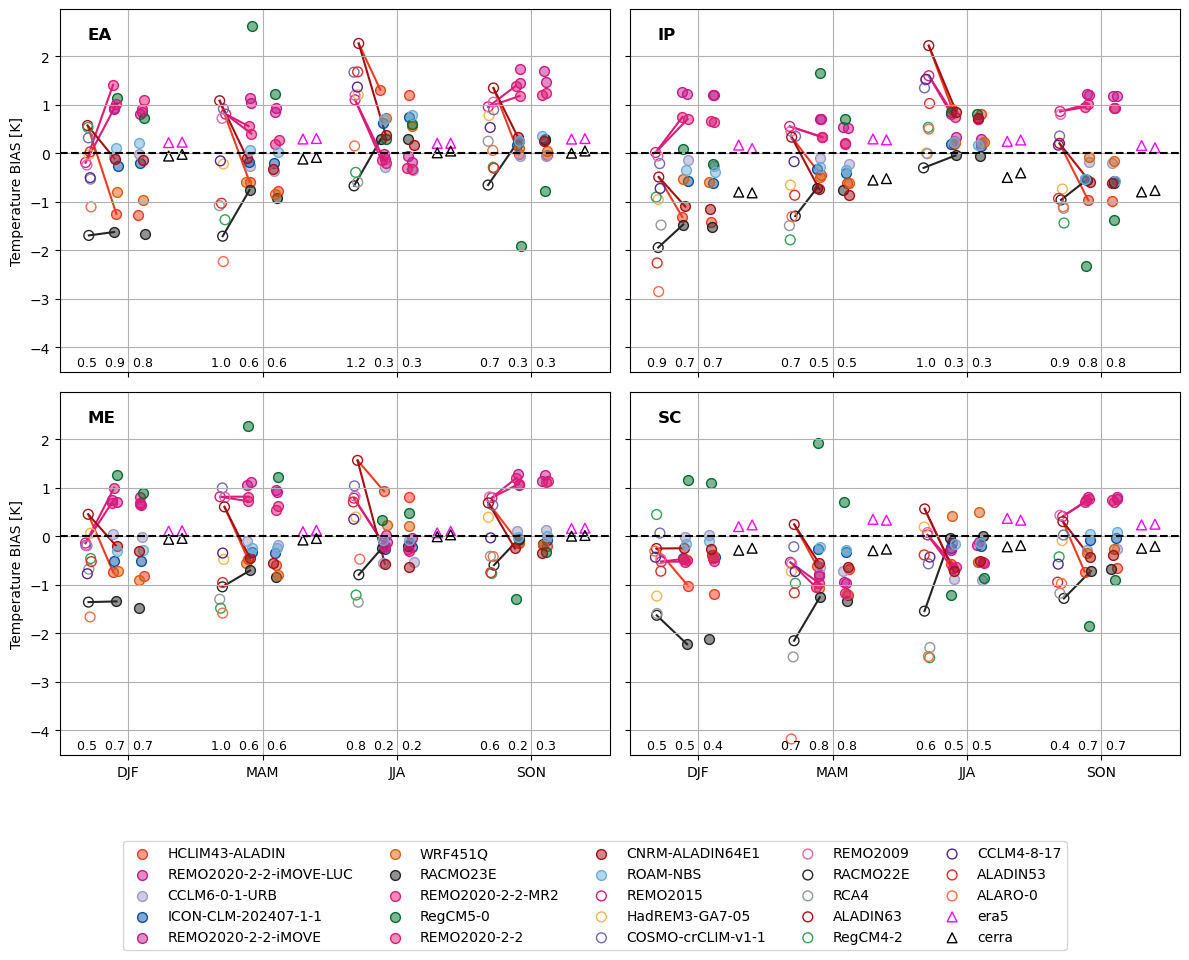

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["EA", "IP", "ME", "SC"]
default_color = "#fb6a4a"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region_fp = df_CMIP6_fp[df_CMIP6_fp["abbrevs"] == region]
    df_CMIP5_region_fp = df_CMIP5_fp[df_CMIP5_fp["abbrevs"] == region]
    df_obs_region_fp = df_obs_fp[df_obs_fp["abbrevs"] == region]

    df_CMIP6_region_sp = df_CMIP6_sp[df_CMIP6_sp["abbrevs"] == region]
    df_CMIP5_region_sp = df_CMIP5_sp[df_CMIP5_sp["abbrevs"] == region]
    df_obs_region_sp = df_obs_sp[df_obs_sp["abbrevs"] == region]

    df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_num"] = df_CMIP5_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region_sp["season_num"] = df_CMIP5_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_fp["season_num"] = df_obs_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_sp["season_num"] = df_obs_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_shifted"] = (
        df_CMIP5_region_fp["season_num"]
        - 0.3
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP5_region_fp["season_num"]))
    )
    df_CMIP6_region_fp["season_shifted"] = (
        df_CMIP6_region_fp["season_num"]
        - 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_fp["season_num"]))
    )
    df_CMIP6_region_sp["season_shifted"] = (
        df_CMIP6_region_sp["season_num"]
        + 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_sp["season_num"]))
    )
    df_obs_region_fp["season_shifted"] = df_obs_region_fp["season_num"] + 0.3
    df_obs_region_sp["season_shifted"] = df_obs_region_sp["season_num"] + 0.4

    # Create lists to store the bias values for calculating median
    cmip6_biases_fp = {season: [] for season in seasons}
    cmip5_biases_fp = {season: [] for season in seasons}

    cmip6_biases_sp = {season: [] for season in seasons}
    cmip5_biases_sp = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region_fp[df_CMIP5_region_fp["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP6_region_sp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_sp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_CMIP5_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip5_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_fp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_sp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.35)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median_fp = (
            np.nanmedian(cmip6_biases_fp[season]) if cmip6_biases_fp[season] else np.nan
        )
        cmip5_median_fp = (
            np.nanmedian(cmip5_biases_fp[season]) if cmip5_biases_fp[season] else np.nan
        )
        cmip6_median_sp = (
            np.nanmedian(cmip6_biases_sp[season]) if cmip6_biases_sp[season] else np.nan
        )
        cmip5_median_sp = (
            np.nanmedian(cmip5_biases_sp[season]) if cmip5_biases_sp[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j - 0.1,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median_fp:.1f}  {cmip6_median_fp:.1f}  {cmip6_median_sp:.1f}",
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_A_bias_{index}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

/tmp/ipykernel_467407/2979109930.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
/tmp/ipykernel_467407/2979109930.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
/tmp/ipykernel_467407/2979109930.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

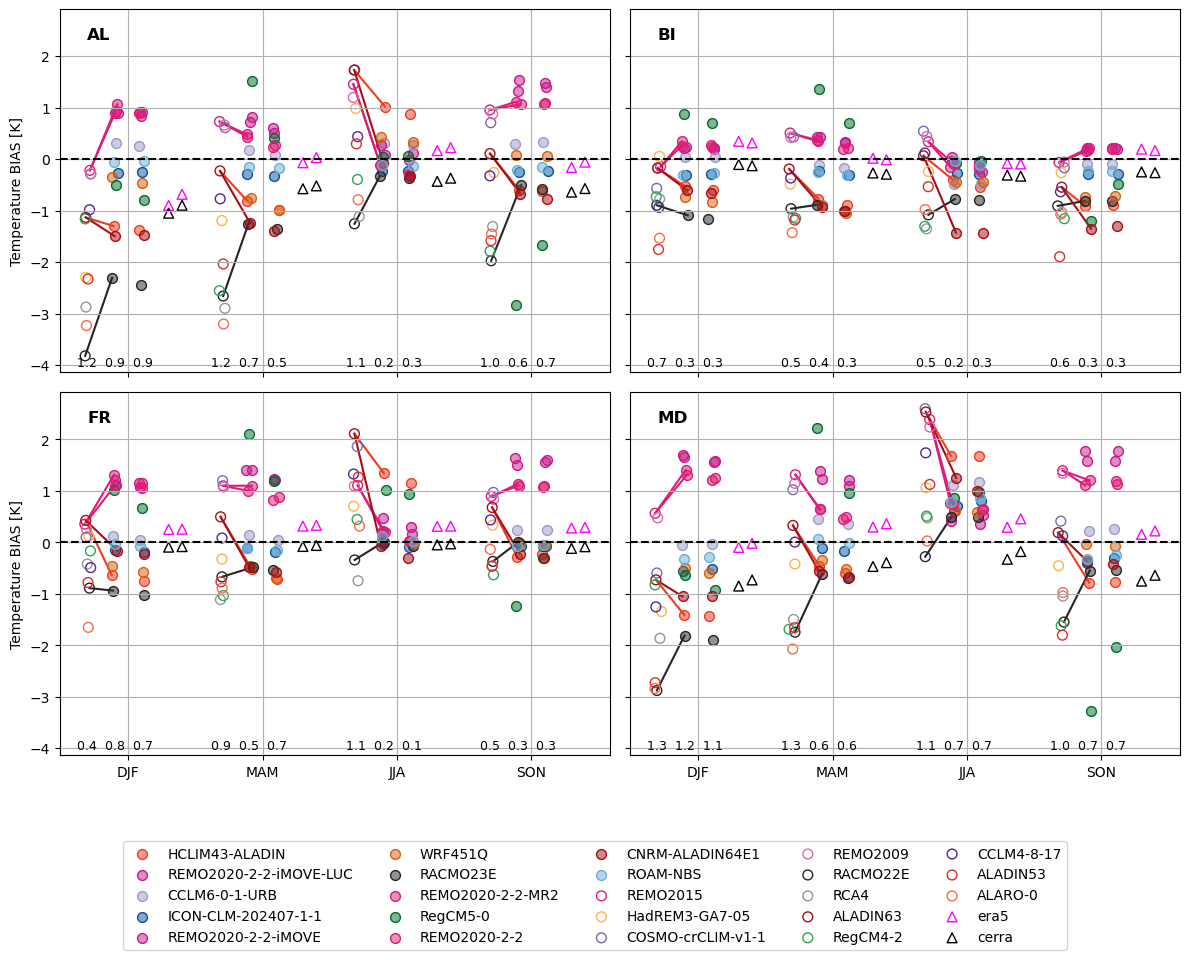

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["AL", "BI", "FR", "MD"]
default_color = "#fb6a4a"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region_fp = df_CMIP6_fp[df_CMIP6_fp["abbrevs"] == region]
    df_CMIP5_region_fp = df_CMIP5_fp[df_CMIP5_fp["abbrevs"] == region]
    df_obs_region_fp = df_obs_fp[df_obs_fp["abbrevs"] == region]

    df_CMIP6_region_sp = df_CMIP6_sp[df_CMIP6_sp["abbrevs"] == region]
    df_CMIP5_region_sp = df_CMIP5_sp[df_CMIP5_sp["abbrevs"] == region]
    df_obs_region_sp = df_obs_sp[df_obs_sp["abbrevs"] == region]

    df_CMIP6_region_fp["season_num"] = df_CMIP6_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP6_region_sp["season_num"] = df_CMIP6_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_num"] = df_CMIP5_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region_sp["season_num"] = df_CMIP5_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_fp["season_num"] = df_obs_region_fp["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region_sp["season_num"] = df_obs_region_sp["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP5_region_fp["season_shifted"] = (
        df_CMIP5_region_fp["season_num"]
        - 0.3
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP5_region_fp["season_num"]))
    )
    df_CMIP6_region_fp["season_shifted"] = (
        df_CMIP6_region_fp["season_num"]
        - 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_fp["season_num"]))
    )
    df_CMIP6_region_sp["season_shifted"] = (
        df_CMIP6_region_sp["season_num"]
        + 0.1
        + np.random.uniform(-0.025, 0.025, size=len(df_CMIP6_region_sp["season_num"]))
    )
    df_obs_region_fp["season_shifted"] = df_obs_region_fp["season_num"] + 0.3
    df_obs_region_sp["season_shifted"] = df_obs_region_sp["season_num"] + 0.4

    # Create lists to store the bias values for calculating median
    cmip6_biases_fp = {season: [] for season in seasons}
    cmip5_biases_fp = {season: [] for season in seasons}

    cmip6_biases_sp = {season: [] for season in seasons}
    cmip5_biases_sp = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region_fp[df_CMIP5_region_fp["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP6_region_sp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor=mcolors.to_rgba(color, 0.5),
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip6_biases_sp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_CMIP5_region_fp.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=50,
        )

        # Collect bias values for median calculation
        cmip5_biases_fp[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_fp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region_sp.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=50,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.35)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median_fp = (
            np.nanmedian(cmip6_biases_fp[season]) if cmip6_biases_fp[season] else np.nan
        )
        cmip5_median_fp = (
            np.nanmedian(cmip5_biases_fp[season]) if cmip5_biases_fp[season] else np.nan
        )
        cmip6_median_sp = (
            np.nanmedian(cmip6_biases_sp[season]) if cmip6_biases_sp[season] else np.nan
        )
        cmip5_median_sp = (
            np.nanmedian(cmip5_biases_sp[season]) if cmip5_biases_sp[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j - 0.1,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median_fp:.1f}  {cmip6_median_fp:.1f}  {cmip6_median_sp:.1f}",
            fontsize=9,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_B_bias_{index}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)